# 15. Tutorial 7: Basic econometric analysis (2)

#### Naoki TANI
#### Center for Advanced Policy Studies (CAPS), Institute of Economic Research, Kyoto University
#### May 30, 2024

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from statsmodels.formula.api import ols, logit, probit
from statsmodels.iolib.summary2 import summary_col
import scipy as sp

## 1. Linear probability model (LPM)
### 1-1. Introduction

#### Consider a simple linear regression model
#### $$Y_{i} = \beta_{0} + \beta_{1} X_{1i} + \beta_{2} X_{2i} + ⋯ + \beta_{k} X_{ki} +u_{i}$$
#### where $Y_{i}$ is a binary dependent variable and $X_{1i}, X_{2i}, ⋯ , X_{ki}$ are independent variables.
#### $Y_{i}$ has only two outcomes and follows Bernoulli distribution.
#### Since $u_{i}=Y_{i}-\beta_{0} - \beta_{1} X_{1i} - \beta_{2} X_{2i} - ⋯ - \beta_{k} X_{ki}$, 
#### $u_{i}$ does not follow normal distribution, but follows Bernoulli distribution.

#### $$
\begin{array}{lcc} 
& u_{i} & \text { Probability } \\
\text { When } Y_{i}=1 & 1 - \beta_{0} - \beta_{1} X_{1i} - \beta_{2} X_{2i} - ⋯ - \beta_{k} X_{ki} & P (Y=1 | X_1, X_2, ⋯ , X_k) \\
\text { When } Y_{i}=0 & -\beta_{0} - \beta_{1} X_{1i} - \beta_{2} X_{2i} - ⋯ - \beta_{k} X_{ki} & 1-P (Y=1 | X_1, X_2, ⋯ , X_k)
\end{array}
$$

#### We have $$E(Y | X_1, X_2, ⋯ , X_k) = 0\times \left[1- P (Y=1 | X_1, X_2, ⋯ , X_k)\right] + 1\times P (Y=1 | X_1, X_2, ⋯ , X_k) $$
#### $$= P (Y=1 | X_1, X_2, ⋯ , X_k)$$
#### We also have $$E(Y | X_1, X_2, ⋯ , X_k) = \beta_{0} + \beta_{1} X_{1i} + \beta_{2} X_{2i} + ⋯ + \beta_{k} X_{ki}$$
#### because the model assumes $E(u_i)=0$ to obtain unbiased estimators.


#### Comparing the above two equations yields 
#### $$P (Y=1 | X_1, X_2, ⋯ , X_k) = \beta_{0} + \beta_{1} X_{1i} + \beta_{2} X_{2i} + ⋯ + \beta_{k} X_{ki}$$
#### So $P (Y=1 | X_1, X_2, ⋯ , X_k)$ is a function of $X_i$.

#### The variance of error term $u_i$ is 
#### $$V(u_{i}) = E[(u_{i}-E[u_{i}])^2]=E[u_{i}^2] = $$
#### $$=(1 - \beta_{0} - \beta_{1} X_{1i} - \beta_{2} X_{2i} - ⋯ - \beta_{k} X_{ki})^2 P (Y=1 | X_1, X_2, ⋯ , X_k) + (- \beta_{0} - \beta_{1} X_{1i} - \beta_{2} X_{2i} - ⋯ - \beta_{k} X_{ki})^2 (1-P (Y=1 | X_1, X_2, ⋯ , X_k)) $$
#### $$=\left(1-P (Y=1 | X_1, X_2, ⋯ , X_k)\right)P (Y=1 | X_1, X_2, ⋯ , X_k).$$
#### Since $P (Y=1 | X_1, X_2, ⋯ , X_k)$ is a function of $X_i$, $u_i$ is heteroskedastic. 
#### We need to use robust standard errors to deal with heteroskedasticity: the example below uses White robust standard error $SE(\hat{\beta}) = \sqrt{\frac{\sum^n_{i=1}(X_i - \bar{x})^2 \hat{u}_i^2}{(\sum^n_{i=1}(X_i - \bar{x})^2)^2}}$ where $\hat{u}_i = Y_{i}-\hat{\beta}_{0} - \hat{\beta}_{1} X_{1i} - \hat{\beta}_{2} X_{2i} - ⋯ - \hat{\beta}_{k} X_{ki}$.
##### (or we can use feasible generalized least squares (FGLS) which is not covered in this lecture.)

#### $\beta_k$ can be interpreted as the change in the probability that $Y_i = 1$ for every $1$-unit of change in $X_{ki}$, holding constant the other regressors.

### 1-2. Example
#### Now we use a survey data to estimate the effect of personal attributes on the probability that the annual income a person requires his or her would-be partner to earn is higher than or equal to his or her income.

In [42]:
kochi_df = pd.read_csv('kochi_survey_mikon.csv')

# create ID column
kochi_df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
kochi_df['ID'] = kochi_df['ID'].astype(int)

# rename column name
kochi_df.rename(columns={'問9':'q9', '問11':'q11', '問12':'q12'}, inplace=True)

# convert data types
kochi_df = kochi_df.astype({'F1':np.float64, 'F2':np.float64, 'F3':np.float64, 'F4':np.float64, 'F5':np.float64, 'F6':np.float64, 'F7':np.float64,\
                          'F8':np.float64, 'F11':np.float64, 'F12':np.float64, 'F13':np.float64, 'q9':np.float64,\
                          'q11':np.float64, 'q12':np.float64})

#
kochi_df['order_wish_earnings'] = kochi_df['q9']
kochi_df.loc[(kochi_df['q9']==8), 'order_wish_earnings'] = 0

# make some dummy variables##################
#college dummy
kochi_df['college_d'] = np.nan
kochi_df.loc[(kochi_df['F3']==1) | (kochi_df['F3']==2) | (kochi_df['F3']==3), 'college_d'] = 0
kochi_df.loc[(kochi_df['F3']==4) | (kochi_df['F3']==5), 'college_d'] = 1
kochi_df

#正規雇用dummy
kochi_df['seiki_d'] = np.nan
kochi_df.loc[(kochi_df['F5']==1) | (kochi_df['F5']==2), 'seiki_d'] = 1
kochi_df.loc[(kochi_df['F5']>=3) & (kochi_df['F3']<=9), 'seiki_d'] = 0
kochi_df
###########################################

# make a binary variable that takes 1 if a person requires his or her partner to earn more than or equal to his or her income
# 自分自身の年収【以上】の年収を相手に求めるか
kochi_df['wish_higher_equal'] = 0
kochi_df.loc[(kochi_df['F6']==1) & ((kochi_df['q9']>=1) & (kochi_df['q9']<=7)), 'wish_higher_equal'] = 1
kochi_df.loc[(kochi_df['F6']==2) & ((kochi_df['q9']>=1) & (kochi_df['q9']<=7)), 'wish_higher_equal'] = 1
kochi_df.loc[(kochi_df['F6']==3) & ((kochi_df['q9']>=1) & (kochi_df['q9']<=7)), 'wish_higher_equal'] = 1
kochi_df.loc[(kochi_df['F6']==4) & ((kochi_df['q9']>=2) & (kochi_df['q9']<=7)), 'wish_higher_equal'] = 1
kochi_df.loc[(kochi_df['F6']==5) & ((kochi_df['q9']>=3) & (kochi_df['q9']<=7)), 'wish_higher_equal'] = 1
kochi_df.loc[(kochi_df['F6']==6) & ((kochi_df['q9']>=4) & (kochi_df['q9']<=7)), 'wish_higher_equal'] = 1
kochi_df.loc[(kochi_df['F6']==7) & ((kochi_df['q9']>=5) & (kochi_df['q9']<=7)), 'wish_higher_equal'] = 1
kochi_df.loc[(kochi_df['F6']==8) & ((kochi_df['q9']>=6) & (kochi_df['q9']<=7)), 'wish_higher_equal'] = 1
kochi_df.loc[(kochi_df['F6']==9) & ((kochi_df['q9']>=7) & (kochi_df['q9']<=7)), 'wish_higher_equal'] = 1
#無回答はNaN
kochi_df.loc[(kochi_df['F6'].isnull()) | (kochi_df['q9'].isnull()),'wish_higher_equal'] = np.nan
kochi_df;

In [43]:
###### 未婚女性
female_df = kochi_df.loc[(kochi_df['F1']==2) & (kochi_df['F4']!=17)]
female_df.rename(columns={'F6':'自身の年収', 'order_wish_earnings':'結婚相手に求める年収'}, inplace=True)


###### 未婚男性
male_df = kochi_df.loc[(kochi_df['F1']==1) & (kochi_df['F4']!=17)]
male_df.rename(columns={'F6':'自身の年収', 'order_wish_earnings':'結婚相手に求める年収'}, inplace=True);

C:\Users\tanin\AppData\Local\Temp\ipykernel_12692\3122827998.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  female_df.rename(columns={'F6':'自身の年収', 'order_wish_earnings':'結婚相手に求める年収'}, inplace=True)
C:\Users\tanin\AppData\Local\Temp\ipykernel_12692\3122827998.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_df.rename(columns={'F6':'自身の年収', 'order_wish_earnings':'結婚相手に求める年収'}, inplace=True);


In [45]:
# make tables to summarize the number of respondents by "自身の年収" and "wish_higher_equal"
f_map=female_df.groupby(['自身の年収','wish_higher_equal']).agg('count')
f_map.reset_index(inplace=True,drop=False) #index外す。
f_map = f_map.loc[:,['自身の年収','wish_higher_equal','ID']]
f_map

m_map=male_df.groupby(['自身の年収','wish_higher_equal']).agg('count')
m_map.reset_index(inplace=True,drop=False) #index外す。
m_map = m_map.loc[:,['自身の年収','wish_higher_equal','ID']]
m_map;

In [46]:
import seaborn as sns

Text(0.5, 1.0, '男性')

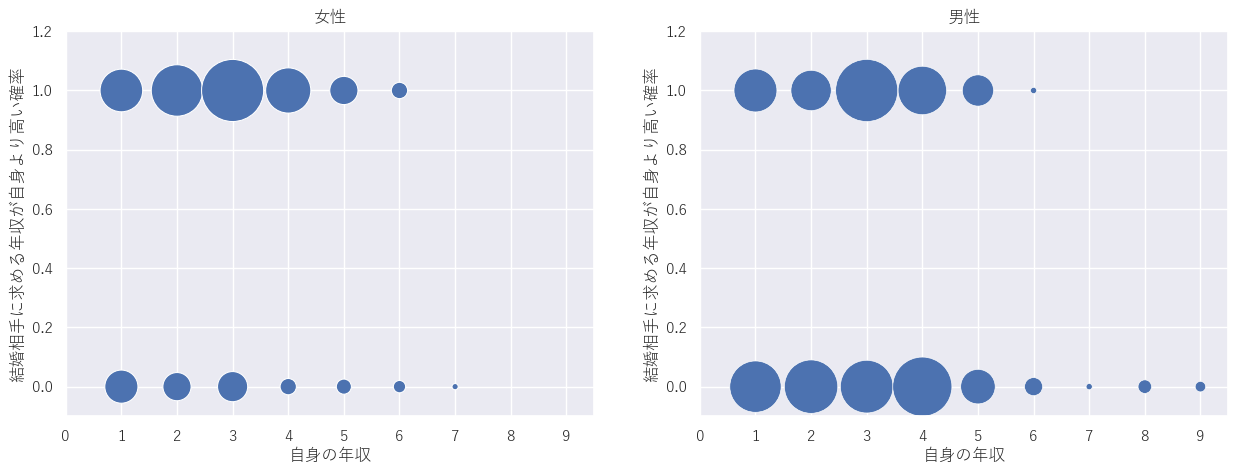

In [47]:
# use the scatterplot function to build the bubble map
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
sns.set(font='Yu Gothic')
sns.scatterplot(data=f_map, x="自身の年収", y="wish_higher_equal", size="ID", legend=False, sizes=(20, 2000), ax=ax1)
sns.scatterplot(data=m_map, x="自身の年収", y="wish_higher_equal", size="ID", legend=False, sizes=(20, 2000), ax=ax2)
ax1.set(xlabel ='自身の年収',ylabel='結婚相手に求める年収が自身より高い確率', xlim=(0,9.5), ylim=(-0.1,1.2))
ax2.set(xlabel ='自身の年収',ylabel='結婚相手に求める年収が自身より高い確率' , xlim=(0,9.5), ylim=(-0.1,1.2))
ax1.set_xticks(np.arange(0,10))
ax2.set_xticks(np.arange(0,10))
ax1.set_title('女性')
ax2.set_title('男性')

In [51]:
female_df = female_df.set_index(['ID'],drop=False) #IDの列をindex化
male_df = male_df.set_index(['ID'],drop=False) #IDの列をindex化

In [116]:
formula1 = 'wish_higher_equal ~ 1 + 自身の年収'
formula2 = 'wish_higher_equal ~ 1 + 自身の年収 + F2 + q11'
formula3 = 'wish_higher_equal ~ 1 + 自身の年収 + F2 + q11 + college_d + seiki_d + C(F4)'

female1 = ols(formula1, data=female_df).fit(cov_type='HC0')
male1 = ols(formula1, data=male_df).fit(cov_type='HC0')
female2 = ols(formula2, data=female_df).fit(cov_type='HC0')
male2 = ols(formula2, data=male_df).fit(cov_type='HC0')
female3 = ols(formula3, data=female_df).fit(cov_type='HC0')
male3 = ols(formula3, data=male_df).fit(cov_type='HC0')

In [125]:
result = summary_col([female1,male1,female2,male2,female3,male3], stars=True, 
                      regressor_order = ['自身の年収','F2','q11','college_d','seiki_d'],#female3.params.index.tolist(), 
                      float_format='%0.4f',
                      model_names=['Female1', 'Male1','Female2', 'Male2','Female3', 'Male3'],
                      info_dict={'N': lambda x: "{0:d}".format(int(x.nobs))},drop_omitted=True)
print(result)
print(female2.summary())


               Female1   Male1    Female2   Male2    Female3   Male3  
----------------------------------------------------------------------
自身の年収          0.0337*  -0.0173  0.0129    -0.0148  0.0029    -0.0180 
               (0.0186) (0.0170) (0.0170)  (0.0176) (0.0226)  (0.0199)
F2                               0.0062    -0.0060  0.0065    -0.0068 
                                 (0.0039)  (0.0051) (0.0041)  (0.0052)
q11                              0.1467*** 0.0338   0.1446*** 0.0339  
                                 (0.0243)  (0.0381) (0.0245)  (0.0416)
college_d                                           0.0151    0.0630  
                                                    (0.0446)  (0.0651)
seiki_d                                             0.0964*   0.0371  
                                                    (0.0530)  (0.0645)
R-squared      0.0107   0.0026   0.1171    0.0096   0.1502    0.0598  
R-squared Adj. 0.0081   -0.0003  0.1103    0.0008   0.1015    -0.0031 
N    

#### The coefficient of `自身の年収` in model `Female1` is $0.0337$ and significant at $5\%$ level. It indicates that in average for each step up the income bracket, the probability that the annual income a person requires his or her would-be partner to earn is higher than or equal to his or her income will increase in $3.37\%$.
#### However, the coefficients are not significant at any level in models `Female2` and `Female3`.
#### Desired number of children has the strongest effect on the dependent variable.

#### However, you could doubt the reliability of the result of LPM.
#### In model `Female2`, if $($ `自身の年収` $,$ `F2` $,$ `q11` $)$ is $(7, 18, 5)$, the model predicts a probability $0.2419 + 7\times 0.0129 + 18\times 0.0062 + 5 \times 0.1467 = 1.1773$ which is more than $1$.
#### The problem that the predicted prbability can be less than 0 or larger than 1 is a defect of LPM.
#### In order to deal with this problem, we can use probit and logit model.

## 2. Probit model
### 2-1. Introduction

#### Binary choice model defines
#### $$
Y_{i} = \begin{cases}
    1 & \text{if} Y_{i}^{*} > 0 \\
    0 & \text{otherwise},
  \end{cases}
$$
#### Latent variable $$Y_{i}^{*} = \beta_{0} + \beta_{1} X_{1i} + \beta_{2} X_{2i} + ⋯ + \beta_{k} X_{ki} +u_{i}$$
#### $$u_{i} | X_{ki} \text{~} F(.).$$

#### Probit model assumes that the error term in the equation of $Y_{i}^{*}$ follows standard normal distribution $N(0,1)$ while logit model assumes that it follows logistic distribution.

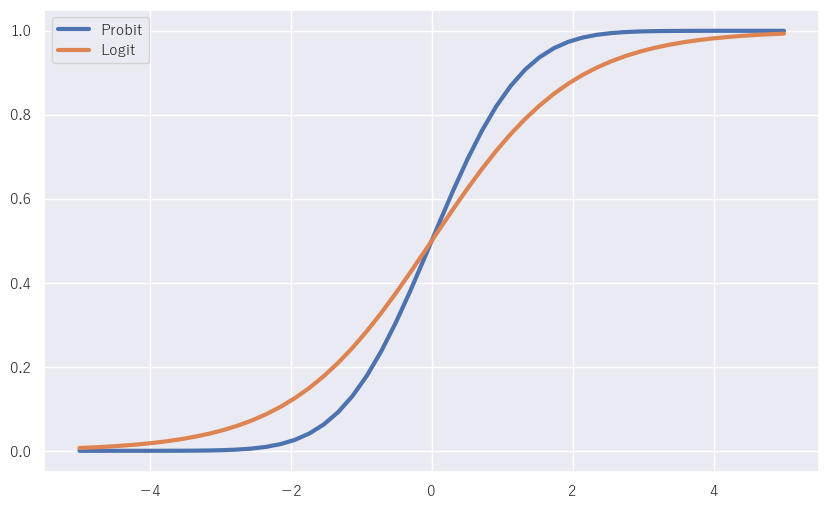

In [130]:
Z = np.linspace(-5, 5)
Y_probit = sp.stats.norm.cdf(Z, loc = 0, scale = 1)
Y_logit = 1/(1+np.exp(-Z))
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(Z, Y_probit, lw =3, label = 'Probit')
ax.plot(Z, Y_logit, lw = 3, label = 'Logit')
ax.legend()
plt.show()

#### In probit model, the conditional probability that $Y_{i}=1$ given $X_{ki}$ is
#### $$P (Y_{i}=1 \ | \ X_{1i}, X_{2i}, ⋯ , X_{ki}) = P(Y_{i}^{*}>0 \ | \ X_{1i}, X_{2i}, ⋯ , X_{ki})$$
#### $$= P(\beta_{0} + \beta_{1} X_{1i} + \beta_{2} X_{2i} + ⋯ + \beta_{k} X_{ki} +u_{i}>0 \ | \ X_{1i}, X_{2i}, ⋯ , X_{ki})$$
#### $$= P(u_{i} > -(\beta_{0} + \beta_{1} X_{1i} + \beta_{2} X_{2i} + ⋯ + \beta_{k} X_{ki}) \ | \ X_{1i}, X_{2i}, ⋯ , X_{ki})$$
##### (because standard normal distribution is symmetric about 0)
#### $$= P(u_{i} < \beta_{0} + \beta_{1} X_{1i} + \beta_{2} X_{2i} + ⋯ + \beta_{k} X_{ki} \ | \ X_{1i}, X_{2i}, ⋯ , X_{ki})$$
#### $$= \Phi(\beta_{0} + \beta_{1} X_{1i} + \beta_{2} X_{2i} + ⋯ + \beta_{k} X_{ki}),$$
#### where $\Phi(.)$ is the cumulative standard normal distribution function.

#### $$P (Y_{i}=0 \ | \ X_{1i}, X_{2i}, ⋯ , X_{ki}) = 1- P(Y_{i}=1 \ | \ X_{1i}, X_{2i}, ⋯ , X_{ki})$$
#### $$=1-\Phi(\beta_{0} + \beta_{1} X_{1i} + \beta_{2} X_{2i} + ⋯ + \beta_{k} X_{ki})$$

#### The cumulative standard normal distribution function is
#### $$\Phi(\beta_{0} + \beta_{1} X_{1i} + \beta_{2} X_{2i} + ⋯ + \beta_{k} X_{ki}) = \int^{\beta_{0} + \beta_{1} X_{1i} + \beta_{2} X_{2i} + ⋯ + \beta_{k} X_{ki}}_{-\infty} \frac{1}{\sqrt{2\pi}}\exp \left(-\frac{z^2}{2}\right)dz$$

#### Solving the maximum likelihood problem below, we can get $(\hat{\beta}_0, \hat{\beta}_1, \hat{\beta}_2, ... ,\hat{\beta}_k)$.

#### $$\max_{\beta_0,\beta_1,...,\beta_k} \sum^{n}_{i=1} [Y_{i}\ln \{\Phi(\beta_{0} + \beta_{1} X_{1i} + \beta_{2} X_{2i} + ⋯ + \beta_{k} X_{ki})\} + (1-Y_{i}) \ln \{1-\Phi(\beta_{0} + \beta_{1} X_{1i} + \beta_{2} X_{2i} + ⋯ + \beta_{k} X_{ki})\} ]$$

In [136]:
female4 = probit(formula1, data=female_df).fit()
male4 = probit(formula1, data=male_df).fit()
female5 = probit(formula2, data=female_df).fit()
male5 = probit(formula2, data=male_df).fit()
female6 = probit(formula3, data=female_df).fit()
male6 = probit(formula3, data=male_df).fit()

Optimization terminated successfully.
         Current function value: 0.538334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.684346
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.488724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.680329
         Iterations 4
         Current function value: 0.462192
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.654357
         Iterations 5


C:\Users\tanin\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [138]:
result2 = summary_col([female4,male4,female5,male5,female6,male6], stars=True, 
                      regressor_order = ['自身の年収','F2','q11','college_d','seiki_d'],#female3.params.index.tolist(), 
                      float_format='%0.4f',
                      model_names=['Female4', 'Male4','Female5', 'Male5','Female6', 'Male6'],
                      info_dict={'N': lambda x: "{0:d}".format(int(x.nobs))},drop_omitted=True)
print(result2)
#print(female4.summary())


          Female4   Male4    Female5   Male5    Female6   Male6  
-----------------------------------------------------------------
自身の年収     0.1067** -0.0450  0.0422    -0.0390  0.0271    -0.0521 
          (0.0533) (0.0472) (0.0580)  (0.0496) (0.0766)  (0.0632)
F2                          0.0213    -0.0152  0.0259    -0.0182 
                            (0.0145)  (0.0130) (0.0159)  (0.0142)
q11                         0.4629*** 0.0863   0.4903*** 0.0903  
                            (0.0761)  (0.0962) (0.0832)  (0.1010)
college_d                                      0.0444    0.1671  
                                               (0.1686)  (0.1679)
seiki_d                                        0.3118    0.1126  
                                               (0.1962)  (0.1841)
N         394      344      393       341      388       336     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
